#Imports

In [1]:
import sys, os, argparse
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F
from PIL import Image
from google.colab.patches import cv2_imshow

import time


#Get Files

In [2]:
!git clone https://github.com/karaposu/HeadOrientationExamples.git 
%cd HeadOrientationExamples/vardanagarwal


Cloning into 'HeadOrientationExamples'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 52 (delta 0), reused 1 (delta 0), pack-reused 49
Unpacking objects: 100% (52/52), done.
/content/HeadOrientationExamples/vardanagarwal


#Load Trained Model

In [7]:


import cv2
import numpy as np
import math
from face_detector import get_face_detector, find_faces
from face_landmarks import get_landmark_model, detect_marks

#Functions

In [8]:
def get_2d_points(img, rotation_vector, translation_vector, camera_matrix, val):
    """Return the 3D points present as 2D for making annotation box"""
    point_3d = []
    dist_coeffs = np.zeros((4,1))
    rear_size = val[0]
    rear_depth = val[1]
    point_3d.append((-rear_size, -rear_size, rear_depth))
    point_3d.append((-rear_size, rear_size, rear_depth))
    point_3d.append((rear_size, rear_size, rear_depth))
    point_3d.append((rear_size, -rear_size, rear_depth))
    point_3d.append((-rear_size, -rear_size, rear_depth))
    
    front_size = val[2]
    front_depth = val[3]
    point_3d.append((-front_size, -front_size, front_depth))
    point_3d.append((-front_size, front_size, front_depth))
    point_3d.append((front_size, front_size, front_depth))
    point_3d.append((front_size, -front_size, front_depth))
    point_3d.append((-front_size, -front_size, front_depth))
    point_3d = np.array(point_3d, dtype=np.float).reshape(-1, 3)
    
    # Map to 2d img points
    (point_2d, _) = cv2.projectPoints(point_3d,
                                      rotation_vector,
                                      translation_vector,
                                      camera_matrix,
                                      dist_coeffs)
    point_2d = np.int32(point_2d.reshape(-1, 2))
    return point_2d

def draw_annotation_box(img, rotation_vector, translation_vector, camera_matrix,
                        rear_size=300, rear_depth=0, front_size=500, front_depth=400,
                        color=(255, 255, 0), line_width=2):
    """
    Draw a 3D anotation box on the face for head pose estimation

    Parameters
    ----------
    img : np.unit8
        Original Image.
    rotation_vector : Array of float64
        Rotation Vector obtained from cv2.solvePnP
    translation_vector : Array of float64
        Translation Vector obtained from cv2.solvePnP
    camera_matrix : Array of float64
        The camera matrix
    rear_size : int, optional
        Size of rear box. The default is 300.
    rear_depth : int, optional
        The default is 0.
    front_size : int, optional
        Size of front box. The default is 500.
    front_depth : int, optional
        Front depth. The default is 400.
    color : tuple, optional
        The color with which to draw annotation box. The default is (255, 255, 0).
    line_width : int, optional
        line width of lines drawn. The default is 2.

    Returns
    -------
    None.

    """
    
    rear_size = 1
    rear_depth = 0
    front_size = img.shape[1]
    front_depth = front_size*2
    val = [rear_size, rear_depth, front_size, front_depth]
    point_2d = get_2d_points(img, rotation_vector, translation_vector, camera_matrix, val)
    # # Draw all the lines
    cv2.polylines(img, [point_2d], True, color, line_width, cv2.LINE_AA)
    cv2.line(img, tuple(point_2d[1]), tuple(
        point_2d[6]), color, line_width, cv2.LINE_AA)
    cv2.line(img, tuple(point_2d[2]), tuple(
        point_2d[7]), color, line_width, cv2.LINE_AA)
    cv2.line(img, tuple(point_2d[3]), tuple(
        point_2d[8]), color, line_width, cv2.LINE_AA)
    
    
def head_pose_points(img, rotation_vector, translation_vector, camera_matrix):
    """
    Get the points to estimate head pose sideways    

    Parameters
    ----------
    img : np.unit8
        Original Image.
    rotation_vector : Array of float64
        Rotation Vector obtained from cv2.solvePnP
    translation_vector : Array of float64
        Translation Vector obtained from cv2.solvePnP
    camera_matrix : Array of float64
        The camera matrix

    Returns
    -------
    (x, y) : tuple
        Coordinates of line to estimate head pose

    """
    rear_size = 1
    rear_depth = 0
    front_size = img.shape[1]
    front_depth = front_size*2
    val = [rear_size, rear_depth, front_size, front_depth]
    point_2d = get_2d_points(img, rotation_vector, translation_vector, camera_matrix, val)
    y = (point_2d[5] + point_2d[8])//2
    x = point_2d[2]
    
    return (x, y)
   

In [ ]:
face_model = get_face_detector()
landmark_model = get_landmark_model()

In [10]:
from PIL import Image
# img = Image.open("a.png")

    
img = cv2.cvtColor(cv2.imread("a.png"), cv2.COLOR_BGR2RGB)
size = img.shape
faces = find_faces(img, face_model)

In [7]:
cap = cv2.VideoCapture(0)
ret, img = cap.read()


AttributeError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


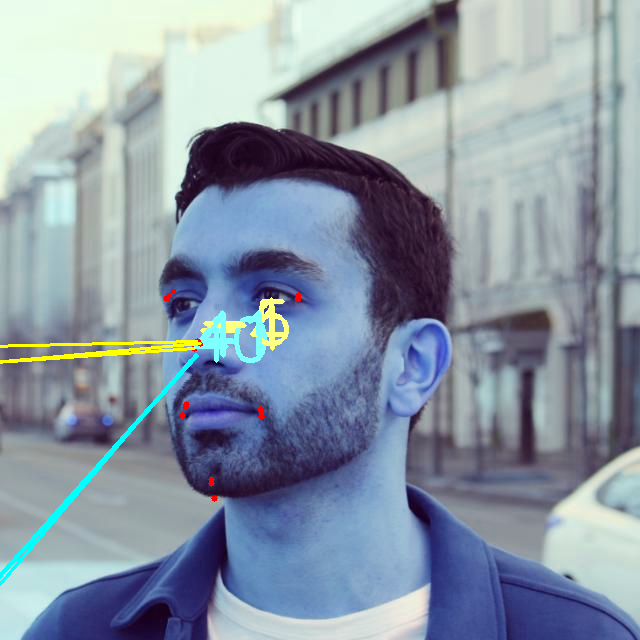

In [13]:


font = cv2.FONT_HERSHEY_SIMPLEX 
# 3D model points.
model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-225.0, 170.0, -135.0),     # Left eye left corner
                            (225.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner
                        ])


focal_length = size[1]
center = (size[1]/2, size[0]/2)
camera_matrix = np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = "double"
                         )




for face in faces:
    marks = detect_marks(img, landmark_model, face)
    # mark_detector.draw_marks(img, marks, color=(0, 255, 0))
    image_points = np.array([
                            marks[30],     # Nose tip
                            marks[8],     # Chin
                            marks[36],     # Left eye left corner
                            marks[45],     # Right eye right corne
                            marks[48],     # Left Mouth corner
                            marks[54]      # Right mouth corner
                        ], dtype="double")
    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_UPNP)
    
    
    # Project a 3D point (0, 0, 1000.0) onto the image plane.
    # We use this to draw a line sticking out of the nose
            
(nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)

for p in image_points:
    cv2.circle(img, (int(p[0]), int(p[1])), 3, (0,0,255), -1)


p1 = ( int(image_points[0][0]), int(image_points[0][1]))
p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
x1, x2 = head_pose_points(img, rotation_vector, translation_vector, camera_matrix)

cv2.line(img, p1, p2, (0, 255, 255), 2)
cv2.line(img, tuple(x1), tuple(x2), (255, 255, 0), 2)
# for (x, y) in marks:
#     cv2.circle(img, (x, y), 4, (255, 255, 0), -1)
# cv2.putText(img, str(p1), p1, font, 1, (0, 255, 255), 1)
try:
    m = (p2[1] - p1[1])/(p2[0] - p1[0])
    ang1 = int(math.degrees(math.atan(m)))
except:
    ang1 = 90
    
try:
    m = (x2[1] - x1[1])/(x2[0] - x1[0])
    ang2 = int(math.degrees(math.atan(-1/m)))
except:
    ang2 = 90
    
    # print('div by zero error')
if ang1 >= 48:
    print('Head down')
    cv2.putText(img, 'Head down', (30, 30), font, 2, (255, 255, 128), 3)
elif ang1 <= -48:
    print('Head up')
    cv2.putText(img, 'Head up', (30, 30), font, 2, (255, 255, 128), 3)
  
if ang2 >= 48:
    print('Head right')
    cv2.putText(img, 'Head right', (90, 30), font, 2, (255, 255, 128), 3)
elif ang2 <= -48:
    print('Head left')
    cv2.putText(img, 'Head left', (90, 30), font, 2, (255, 255, 128), 3)

cv2.putText(img, str(ang1), tuple(p1), font, 2, (128, 255, 255), 3)
cv2.putText(img, str(ang2), tuple(x1), font, 2, (255, 255, 128), 3)

from google.colab.patches import cv2_imshow
cv2_imshow( img)


